In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load train-test split datasets for all stocks

# NVIDIA
X_train_nvidia = pd.read_csv("../data/tt_splits/X_train_nvidia.csv", parse_dates=["Date"], index_col="Date")
X_test_nvidia = pd.read_csv("../data/tt_splits/X_test_apple.csv", parse_dates=["Date"], index_col="Date")
y_train_nvidia = pd.read_csv("../data/tt_splits/y_train_nvidia.csv", parse_dates=["Date"], index_col="Date")
y_test_nvidia = pd.read_csv("../data/tt_splits/y_test_nvidia.csv", parse_dates=["Date"], index_col="Date")

# Apple
X_train_apple = pd.read_csv("../data/tt_splits/X_train_apple.csv", parse_dates=["Date"], index_col="Date")
X_test_apple = pd.read_csv("../data/tt_splits/X_test_apple.csv", parse_dates=["Date"], index_col="Date")
y_train_apple = pd.read_csv("../data/tt_splits/y_train_apple.csv", parse_dates=["Date"], index_col="Date")
y_test_apple = pd.read_csv("../data/tt_splits/y_test_apple.csv", parse_dates=["Date"], index_col="Date")

# Microsoft
X_train_microsoft = pd.read_csv("../data/tt_splits/X_train_microsoft.csv", parse_dates=["Date"], index_col="Date")
X_test_microsoft = pd.read_csv("../data/tt_splits/X_test_microsoft.csv", parse_dates=["Date"], index_col="Date")
y_train_microsoft = pd.read_csv("../data/tt_splits/y_train_microsoft.csv", parse_dates=["Date"], index_col="Date")
y_test_microsoft = pd.read_csv("../data/tt_splits/y_test_microsoft.csv", parse_dates=["Date"], index_col="Date")

# Display first few rows of y_train to confirm structure
y_train_nvidia.head(), y_train_apple.head(), y_train_microsoft

(            Future_Return_5d
 Date                        
 1999-11-04          0.040686
 1999-11-05          0.132752
 1999-11-08          0.079575
 1999-11-09          0.200889
 1999-11-10          0.257701,
             Future_Return_5d
 Date                        
 1981-09-28          0.182613
 1981-09-29          0.115710
 1981-09-30          0.172135
 1981-10-01          0.213116
 1981-10-02          0.128779,
             Future_Return_5d
 Date                        
 1986-12-24         -0.032910
 1986-12-26          0.025379
 1986-12-29          0.084650
 1986-12-30          0.130888
 1986-12-31          0.155436
 ...                      ...
 2017-06-16          0.017286
 2017-06-19         -0.004798
 2017-06-20         -0.010013
 2017-06-21         -0.006689
 2017-06-22         -0.025192
 
 [7687 rows x 1 columns])

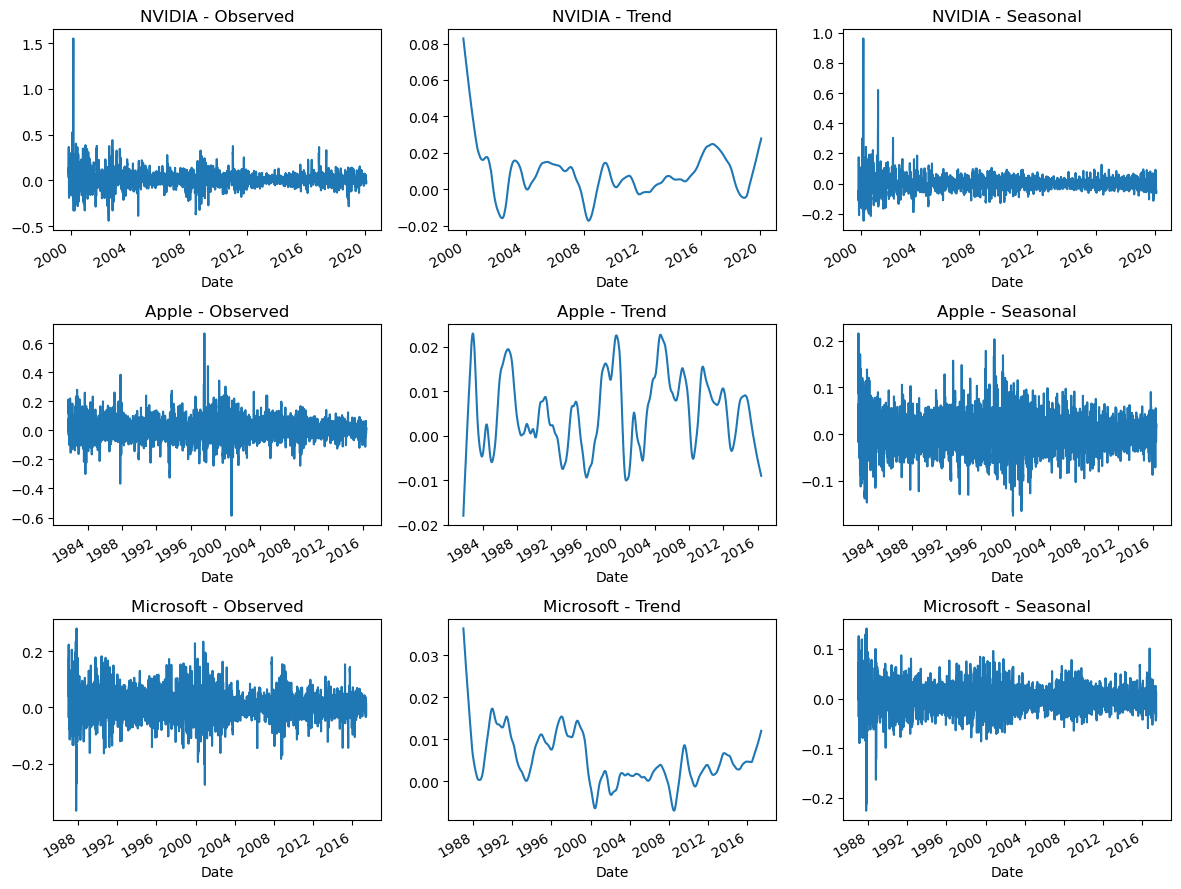

In [3]:
# Define a seasonal period (try 5, 20, 252)
seasonal_period = 252  # Change this to 5 or 20 to test different periods

# Perform STL decomposition
stl_nvidia = sm.tsa.STL(y_train_nvidia["Future_Return_5d"], period=seasonal_period).fit()
stl_apple = sm.tsa.STL(y_train_apple["Future_Return_5d"], period=seasonal_period).fit()
stl_microsoft = sm.tsa.STL(y_train_microsoft["Future_Return_5d"], period=seasonal_period).fit()

# Plot STL decomposition results
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

# NVIDIA
stl_nvidia.observed.plot(ax=axes[0, 0], title="NVIDIA - Observed")
stl_nvidia.trend.plot(ax=axes[0, 1], title="NVIDIA - Trend")
stl_nvidia.seasonal.plot(ax=axes[0, 2], title="NVIDIA - Seasonal")

# Apple
stl_apple.observed.plot(ax=axes[1, 0], title="Apple - Observed")
stl_apple.trend.plot(ax=axes[1, 1], title="Apple - Trend")
stl_apple.seasonal.plot(ax=axes[1, 2], title="Apple - Seasonal")

# Microsoft
stl_microsoft.observed.plot(ax=axes[2, 0], title="Microsoft - Observed")
stl_microsoft.trend.plot(ax=axes[2, 1], title="Microsoft - Trend")
stl_microsoft.seasonal.plot(ax=axes[2, 2], title="Microsoft - Seasonal")

plt.tight_layout()
plt.show()

**Trend Component:**
- The Trend plots show long-term fluctuations in Future Return 5D.
- For all three stocks, the trend does not follow a clear upward or downward direction but rather oscillates over time.
- This suggests that stock returns fluctuate over different market cycles rather than following a simple trend.
- The trend exists but is not strongly directional, meaning momentum-based forecasting may not be reliable.
- Stock returns are inherently mean-reverting, meaning they do not exhibit a consistent upward or downward trend.

**Seasonal Component:**
- The Seasonal plots show noisy fluctuations rather than a clear, repeating seasonal cycle.
- The seasonal variations are not periodic, which means that returns do not follow a strict weekly, monthly, or yearly cycle.
- The seasonal amplitude reduces over time, suggesting that early years had more extreme fluctuations compared to recent years.
- No strong seasonality detected, confirming that SARIMA is unnecessary.
- The fluctuations might be driven more by market volatility than actual seasonal factors.

**Observed Component:**
- The Observed plots show volatile fluctuations in stock returns, with larger spikes in earlier years.
- This aligns with the idea that stock returns are highly volatile and do not follow a fixed pattern.
- Outliers are present, especially in NVIDIA (early 2000s), Apple (late 1990s), and Microsoft (early 1990s and 2000s), which could be linked to major market events (tech bubble, financial crises, etc.).
- The return series appears noisy and influenced by market shocks rather than seasonality.
- Any forecasting model will need to account for volatility and unpredictability rather than relying on smooth seasonal cycles.

Text(0.5, 1.0, 'MICROSOFT - PACF')

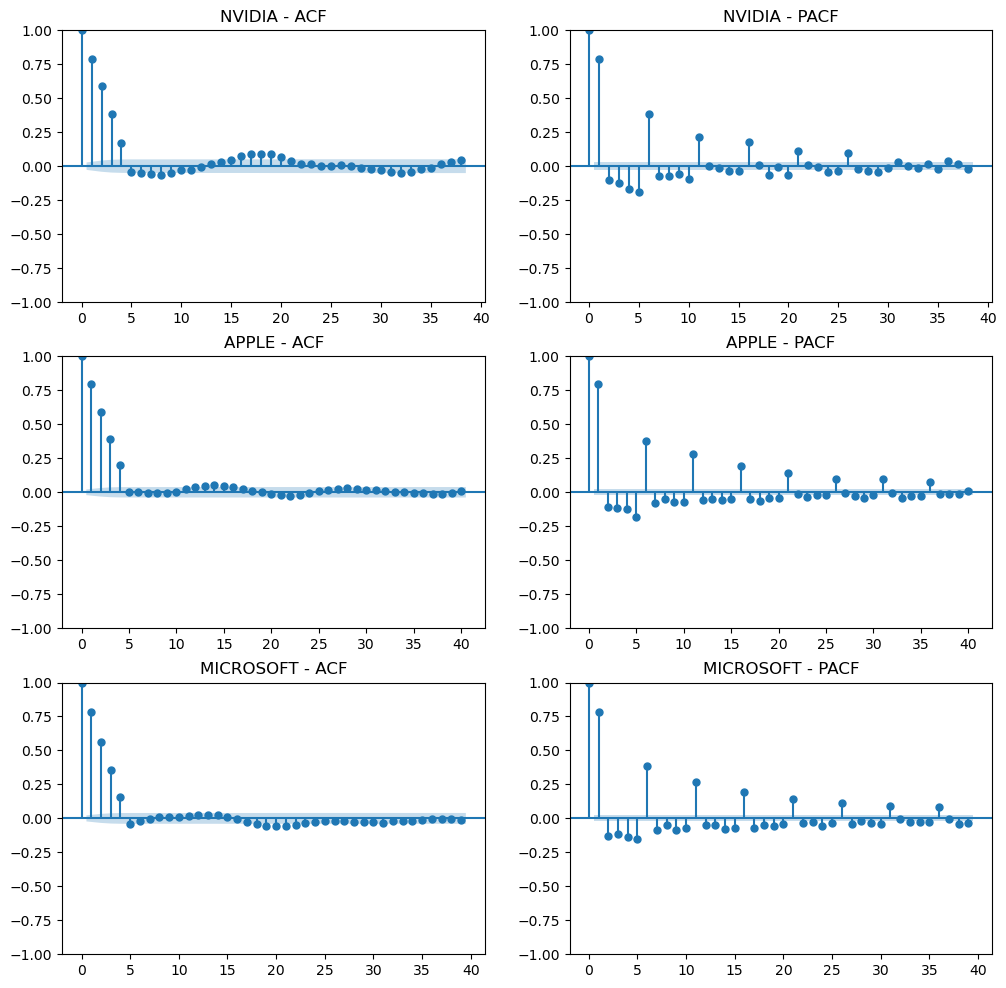

In [4]:
# Plot ACF & PACF for NVIDIA, Apple and Microsoft Future Return 5D
fig, axes = plt.subplots(3,2,figsize=(12,12))

plot_acf(y_train_nvidia['Future_Return_5d'].dropna(), ax=axes[0,0])
plot_pacf(y_train_nvidia['Future_Return_5d'].dropna(), ax=axes[0,1])
axes[0,0].set_title("NVIDIA - ACF")
axes[0,1].set_title("NVIDIA - PACF")

plot_acf(y_train_apple['Future_Return_5d'].dropna(), ax=axes[1,0])
plot_pacf(y_train_apple['Future_Return_5d'].dropna(), ax=axes[1,1])
axes[1,0].set_title("APPLE - ACF")
axes[1,1].set_title("APPLE - PACF")

plot_acf(y_train_microsoft['Future_Return_5d'].dropna(), ax=axes[2,0])
plot_pacf(y_train_microsoft['Future_Return_5d'].dropna(), ax=axes[2,1])
axes[2,0].set_title("MICROSOFT - ACF")
axes[2,1].set_title("MICROSOFT - PACF")

**Interpretation of ACF & PACF Plots:**
- The ACF plots for all three stocks (NVIDIA, Apple, Microsoft) show a gradual decline with significant lags, indicating persistence in the time series.
- The PACF plots show sharp cutoffs after a few lags (around lag 2 to 3) for all stocks, suggesting that an AR(2) or AR(3) model could be appropriate.
- The presence of gradually declining ACF and cutoff PACF is a strong indication of an ARMA or ARIMA model being well-suited.

From these plots, initial parameter estimates:
- p (AR term) ≈ 2 or 3 (from PACF cutoff).
- q (MA term) ≈ 2 or 3 (from ACF gradual decline).
- d (Differencing term) should be confirmed by stationarity tests.

Let's now run Auto ARIMA to compare the automatically selected `p`,`d`,`q` values against our manually inferred values.

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [6]:
auto_arima_nvidia = auto_arima(y_train_nvidia ['Future_Return_5d'], seasonal=False, trace=True, suppress_warnings=True)
auto_arima_apple = auto_arima(y_train_apple ['Future_Return_5d'], seasonal=False, trace=True, suppress_warnings=True)
auto_arima_microsoft = auto_arima(y_train_microsoft ['Future_Return_5d'], seasonal=False, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-15473.132, Time=4.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-10121.582, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-15153.399, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-13108.511, Time=0.52 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-15218.612, Time=1.90 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-15330.684, Time=1.76 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-15349.408, Time=3.45 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-16001.396, Time=3.27 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-15652.601, Time=1.77 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-16140.462, Time=4.16 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-16177.291, Time=4.63 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-16213.870, Time=4.73 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-15458.736, Time=3.91 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-16399.412, Time=5.76 sec
 ARIM

In [7]:
# Extract Best Order(p,d,q)
best_orders = {
    'NVIDIA': auto_arima_nvidia.order,
    'Apple': auto_arima_apple.order,
    'Microsoft': auto_arima_microsoft.order
}

best_orders

{'NVIDIA': (5, 0, 4), 'Apple': (3, 0, 2), 'Microsoft': (0, 1, 0)}

- For NVIDIA, Auto ARIMA suggests a higher complexity model (p=5, q=4) than we estimated. We can test if a simpler model performs just as well.
- For Apple, the Auto ARIMA result exactly matches our manual estimate (p=3, d=0, q=2), confirming our ACF/PACF analysis.
- For Microsoft, Auto ARIMA suggests a simpler model (0,1,0), meaning only differencing is needed, with no AR or MA terms.

In [8]:
# Initialize ARIMA models using Auto ARIMA parameters

arima_nvidia = sm.tsa.ARIMA(y_train_nvidia['Future_Return_5d'], order=(5,0,4))
arima_apple = sm.tsa.ARIMA(y_train_apple['Future_Return_5d'], order=(3,0,2))
arima_microsoft = sm.tsa.ARIMA(y_train_microsoft['Future_Return_5d'], order=(0,1,0))

# Fit Models
arima_nvidia_fit = arima_nvidia.fit()
arima_apple_fit = arima_apple.fit()
arima_microsoft_fit = arima_microsoft.fit()

c:\Users\athar\anaconda3\envs\ds_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\athar\anaconda3\envs\ds_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [9]:
# Forecast on test set
y_pred_nvidia = arima_nvidia_fit.forecast(steps=len(y_test_nvidia))
y_pred_apple = arima_apple_fit.forecast(steps=len(y_test_apple))
y_pred_microsoft = arima_microsoft_fit.forecast(steps=len(y_test_microsoft))

In [10]:
# Evaluate RMSE
rmse_nvidia = np.sqrt(mean_squared_error(y_test_nvidia, y_pred_nvidia))
rmse_apple = np.sqrt(mean_squared_error(y_test_apple, y_pred_apple))
rmse_microsoft = np.sqrt(mean_squared_error(y_test_microsoft, y_pred_microsoft))

In [11]:
# Print results
print(f"ARIMA Model RMSE:")
print(f"NVIDIA: {rmse_nvidia}")
print(f"Apple: {rmse_apple}")
print(f"Microsoft: {rmse_microsoft}")

ARIMA Model RMSE:
NVIDIA: 0.0720678022853811
Apple: 0.03771591710371061
Microsoft: 0.045448318914776555


**What do these values mean?**
1. Apple has the lowest RMSE (0.0377)
- This suggests that the ARIMA model for Apple provides the most accurate forecasts among the three stocks.
- This aligns with our ACF/PACF manual estimate matching the Auto ARIMA result.

2. Microsoft's RMSE is slightly higher (0.0454)
- Since Auto ARIMA selected (0,1,0), this means only differencing was applied without any AR/MA terms.
- This might indicate that Microsoft's returns are more random, with no strong AR or MA relationships.

3. NVIDIA has the highest RMSE (0.0721)
- This suggests that the (5,0,4) model may be overfitting or not generalizing well.
- We might try a simpler model (e.g., (3,0,2)) to check if reducing complexity improves performance.

In [12]:
# Simpler model for NVIDIA
arima_nvidia_simpler = sm.tsa.ARIMA(y_train_nvidia['Future_Return_5d'], order=(3,0,2))
arima_nvidia_simpler_fit = arima_nvidia_simpler.fit()

# Forecast with the new model
y_pred_nvidia_simpler = arima_nvidia_simpler_fit.forecast(steps=len(y_test_nvidia))

# Evaluate RMSE for simpler model
rmse_nvidia_simpler = np.sqrt(mean_squared_error(y_test_nvidia, y_pred_nvidia_simpler))

# Compare RMSE results
rmse_nvidia, rmse_nvidia_simpler

c:\Users\athar\anaconda3\envs\ds_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\athar\anaconda3\envs\ds_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0.0720678022853811, 0.07208357796935522)

- The simpler model (3,0,2) performs almost identically to the complex model (5,0,4).
- Since the RMSE difference is negligible, we might prefer the simpler model because lower risk of overfitting and easier interpretation and faster computation.

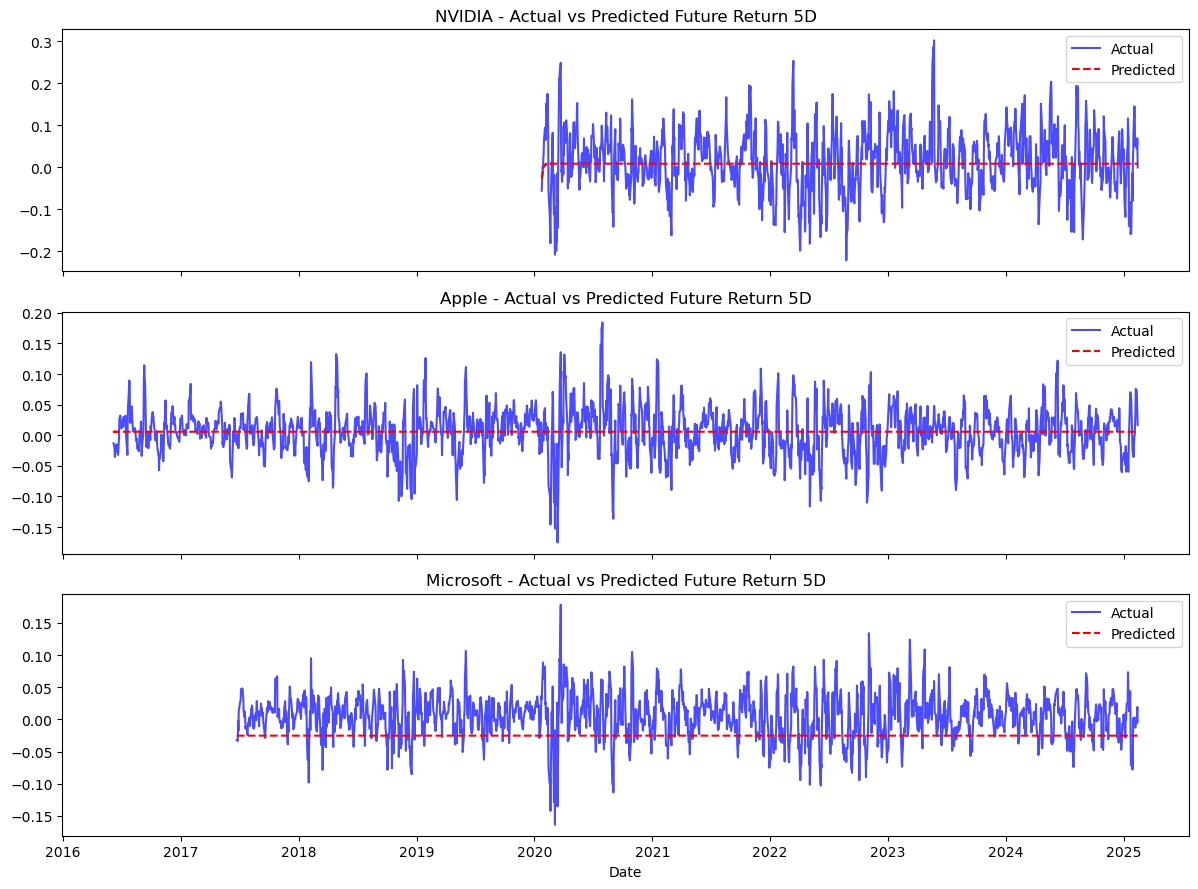

In [13]:
# Plot Actual vs. Predicted for NVIDIA, Apple, and Microsoft
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# NVIDIA
axes[0].plot(y_test_nvidia.index, y_test_nvidia, label="Actual", color='blue', alpha=0.7)
axes[0].plot(y_test_nvidia.index, y_pred_nvidia_simpler, label="Predicted", color='red', linestyle="dashed")
axes[0].set_title("NVIDIA - Actual vs Predicted Future Return 5D")
axes[0].legend()

# Apple
axes[1].plot(y_test_apple.index, y_test_apple, label="Actual", color='blue', alpha=0.7)
axes[1].plot(y_test_apple.index, y_pred_apple, label="Predicted", color='red', linestyle="dashed")
axes[1].set_title("Apple - Actual vs Predicted Future Return 5D")
axes[1].legend()

# Microsoft
axes[2].plot(y_test_microsoft.index, y_test_microsoft, label="Actual", color='blue', alpha=0.7)
axes[2].plot(y_test_microsoft.index, y_pred_microsoft, label="Predicted", color='red', linestyle="dashed")
axes[2].set_title("Microsoft - Actual vs Predicted Future Return 5D")
axes[2].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()

**Why are our prediction plots flat ?**
1. ARIMA Models Tend to Forecast Mean-Reverting Series
- ARIMA models are designed to capture trend and autocorrelations, but they struggle with highly volatile, mean-reverting series like stock returns.
- Future Return 5D is inherently noisy and has low autocorrelation, making it difficult for ARIMA to detect patterns.

2. Low Predictability in Stock Returns
- The stock market is largely random (efficient market hypothesis), meaning that past returns often have little predictive power over future returns.
- This is especially true for returns-based forecasting rather than price-based forecasting.

3. High Differencing (d=1 for Microsoft)
- Since Microsoft’s ARIMA model (0,1,0) only uses differencing, it removes any potential trend or autocorrelation, resulting in an almost constant prediction.

4. Overfitting During Training, Underperformance in Testing
- The ARIMA models may be overfitting on historical noise rather than meaningful patterns.

Let's run this on our original dataset instead with `Close` as the target variable

In [14]:
# Load stock datasets
nvidia_stock = pd.read_csv('../data/nvidia_stock.csv', parse_dates=['Date'], index_col='Date')
apple_stock = pd.read_csv('../data/apple_stock.csv', parse_dates=['Date'], index_col='Date')
microsoft_stock = pd.read_csv('../data/microsoft_stock.csv', parse_dates=['Date'], index_col='Date')

from numpy.fft import fft
fft_values_nvidia = fft(nvidia_stock['Close'].dropna())
frequencies = np.fft.fftfreq(len(fft_values_nvidia))
fft_values_apple = fft(apple_stock['Close'].dropna())
apple_frequencies = np.fft.fftfreq(len(fft_values_apple))
fft_values_microsoft = fft(microsoft_stock['Close'].dropna())
microsoft_frequencies = np.fft.fftfreq(len(fft_values_microsoft))

In [15]:
# Dictionary of stock data
stocks = {
    "NVIDIA": nvidia_stock['Close'],
    "Apple": apple_stock['Close'],
    "Microsoft": microsoft_stock['Close']
}

# Function to perform ADF test
def adf_test(stock_name, stock_data):
    result = adfuller(stock_data.dropna())
    print(f"ADF Test Results for {stock_name}:")
    print("--------------------------------")
    print(f"ADF Test Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    
    if result[1] <= 0.05:
        print(f"Reject the null hypothesis (H₀) - {stock_name} data is stationary.\n")
    else:
        print(f"Fail to reject the null hypothesis (H₀) - {stock_name} data is NOT stationary.\n")

# Run ADF test for all stocks
for stock_name, stock_data in stocks.items():
    adf_test(stock_name, stock_data)

ADF Test Results for NVIDIA:
--------------------------------
ADF Test Statistic: 4.086895313762889
p-value: 1.0
Critical Values: {'1%': -3.4313524324299673, '5%': -2.861982989538709, '10%': -2.567005799943628}
Fail to reject the null hypothesis (H₀) - NVIDIA data is NOT stationary.

ADF Test Results for Apple:
--------------------------------
ADF Test Statistic: 4.850138980026266
p-value: 1.0
Critical Values: {'1%': -3.4309393155269223, '5%': -2.8618004452473955, '10%': -2.566908629884302}
Fail to reject the null hypothesis (H₀) - Apple data is NOT stationary.

ADF Test Results for Microsoft:
--------------------------------
ADF Test Statistic: 3.9641171425477637
p-value: 1.0
Critical Values: {'1%': -3.4310192263397825, '5%': -2.86183575747997, '10%': -2.566927426580226}
Fail to reject the null hypothesis (H₀) - Microsoft data is NOT stationary.



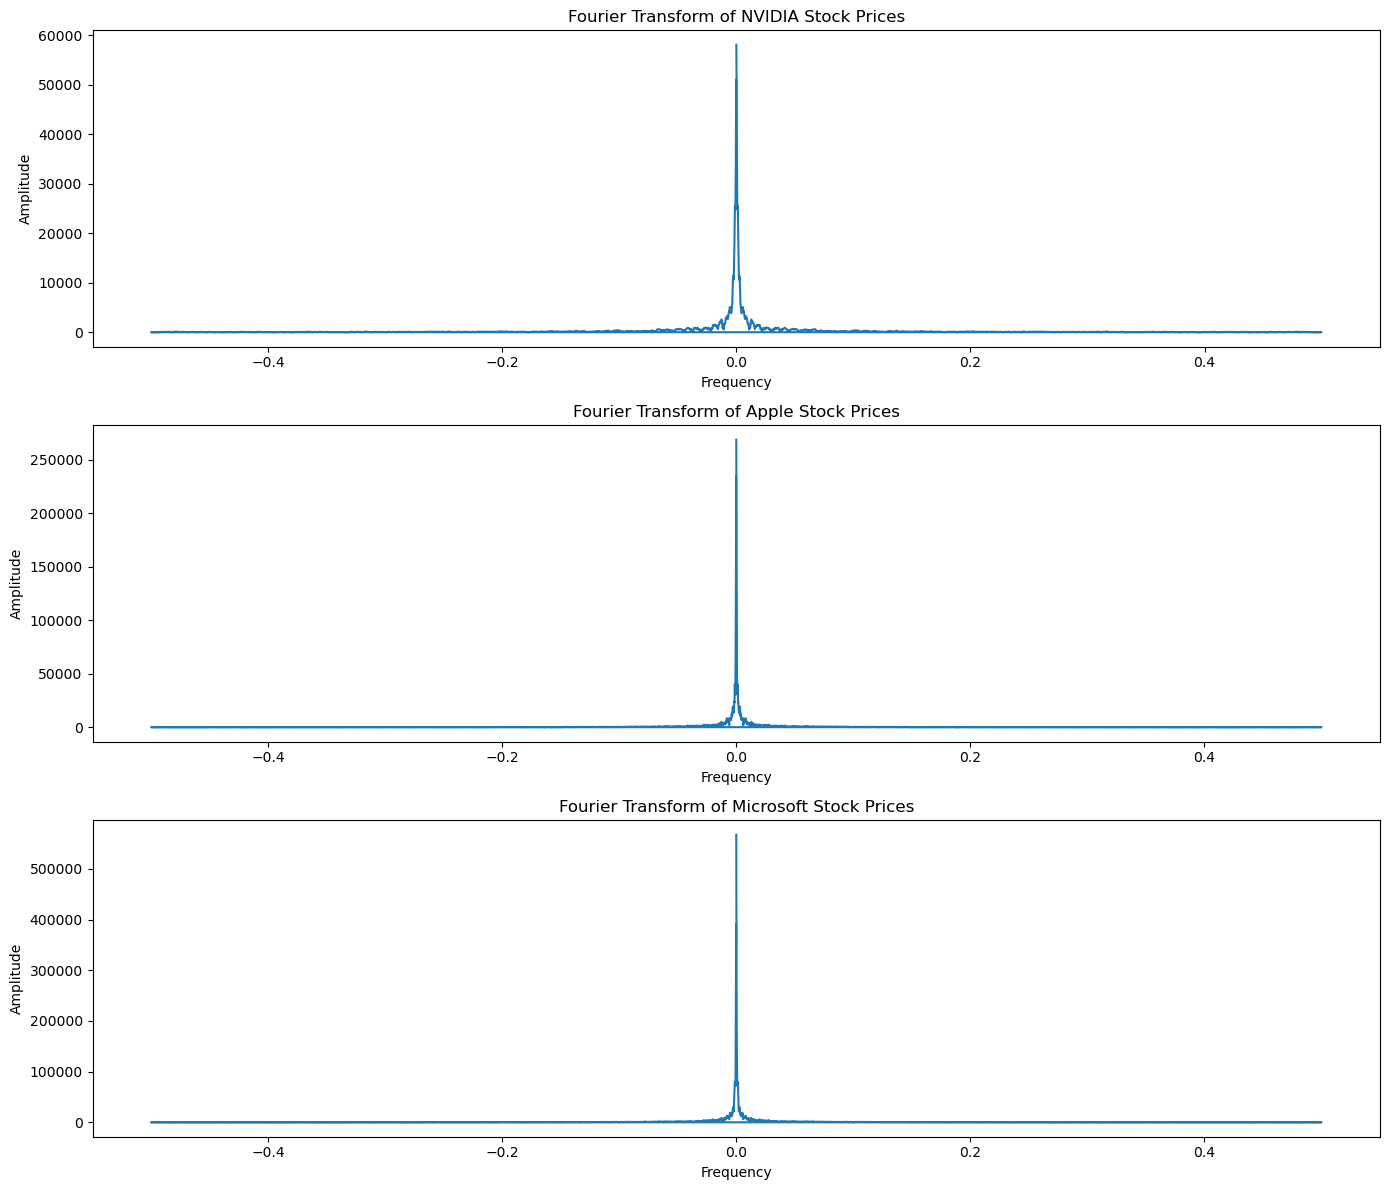

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# NVIDIA
axes[0].plot(frequencies, np.abs(fft_values_nvidia))
axes[0].set_title('Fourier Transform of NVIDIA Stock Prices')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Amplitude')

# Apple
axes[1].plot(apple_frequencies, np.abs(fft_values_apple))
axes[1].set_title('Fourier Transform of Apple Stock Prices')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Amplitude')

# Microsoft
axes[2].plot(microsoft_frequencies, np.abs(fft_values_microsoft))
axes[2].set_title('Fourier Transform of Microsoft Stock Prices')
axes[2].set_xlabel('Frequency')
axes[2].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

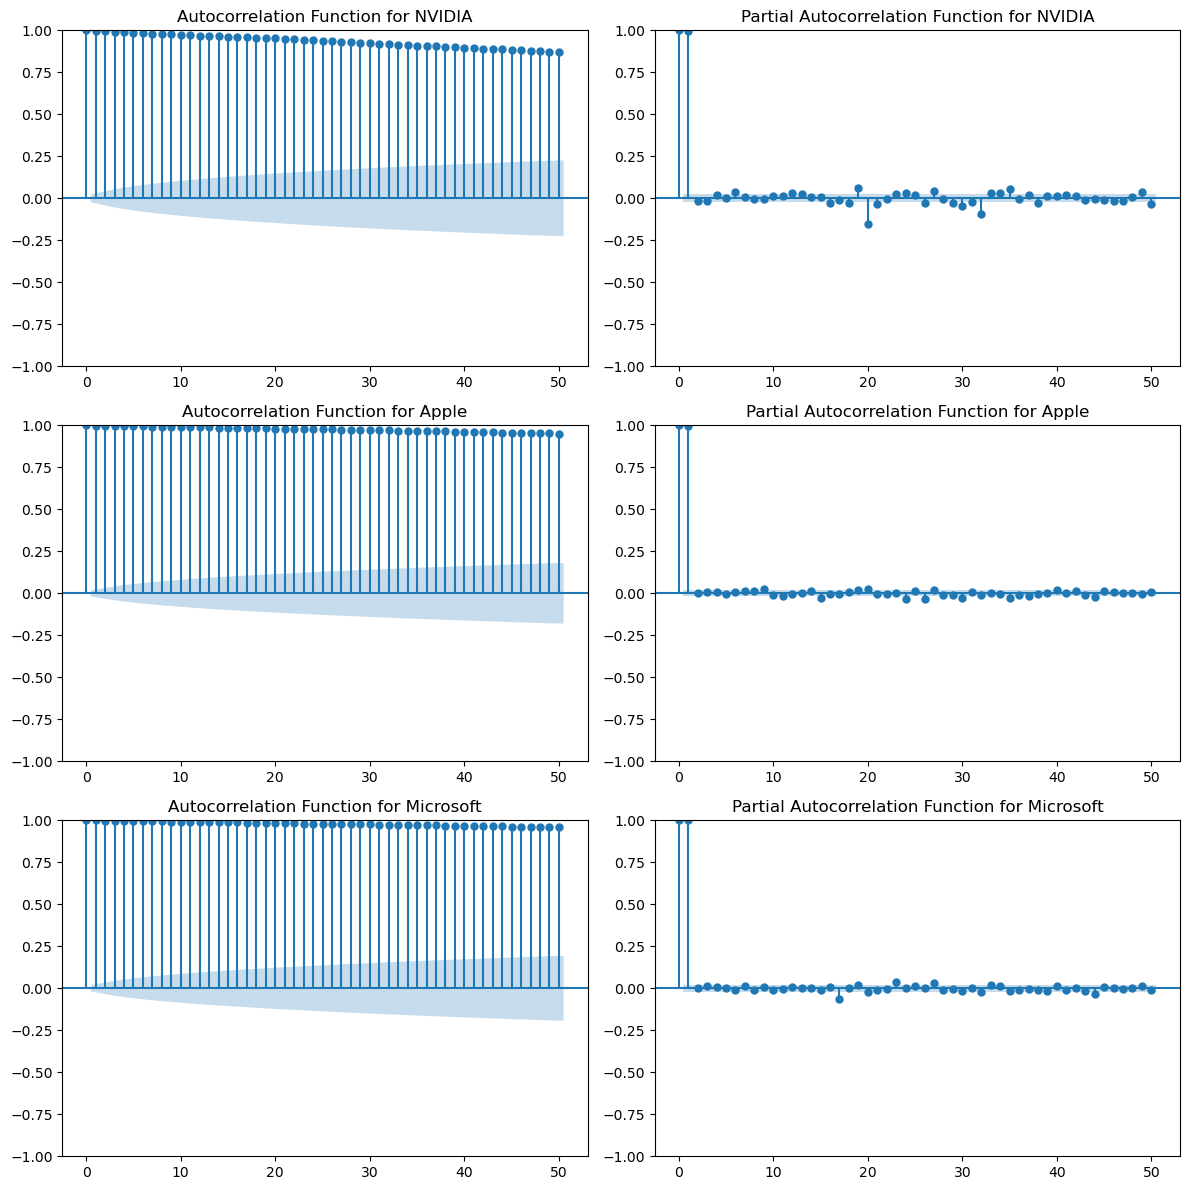

In [17]:
# Plot ACF and PCF for NVIDIA, Apple and Microsoft
fig, axes = plt.subplots(3,2,figsize=(12,12))

# NVIDIA
plot_acf(nvidia_stock['Close'].dropna(), lags=50, ax=axes[0, 0])
axes[0, 0].set_title('Autocorrelation Function for NVIDIA')

plot_pacf(nvidia_stock['Close'].dropna(), lags=50, ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation Function for NVIDIA')

# Apple
plot_acf(apple_stock['Close'].dropna(), lags=50, ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation Function for Apple')

plot_pacf(apple_stock['Close'].dropna(), lags=50, ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation Function for Apple')

# Microsoft
plot_acf(microsoft_stock['Close'].dropna(), lags=50, ax=axes[2, 0])
axes[2, 0].set_title('Autocorrelation Function for Microsoft')

plot_pacf(microsoft_stock['Close'].dropna(), lags=50, ax=axes[2, 1])
axes[2, 1].set_title('Partial Autocorrelation Function for Microsoft')

plt.tight_layout()
plt.show()

In [18]:
# from statsmodels.tsa.arima.model import ARIMA

arima_model_nvidia = ARIMA(nvidia_stock['Close'].dropna(), order=(5, 2, 0))
arima_result_nvidia = arima_model_nvidia.fit()
arima_model_apple = ARIMA(apple_stock['Close'].dropna(), order=(5,2,0))
arima_result_apple = arima_model_apple.fit()
arima_model_microsoft = ARIMA(microsoft_stock['Close'].dropna(), order=(5,2,0))
arima_result_microsoft = arima_model_microsoft.fit()

nvidia_stock['ARIMA_Prediction'] = arima_result_nvidia.predict(start=0, end=len(nvidia_stock)-1, dynamic=False)
apple_stock['ARIMA_Prediction'] = arima_result_apple.predict(start=0, end=len(apple_stock)-1, dynamic=False)
microsoft_stock['ARIMA_Prediction'] = arima_result_microsoft.predict(start=0, end=len(microsoft_stock)-1, dynamic=False)

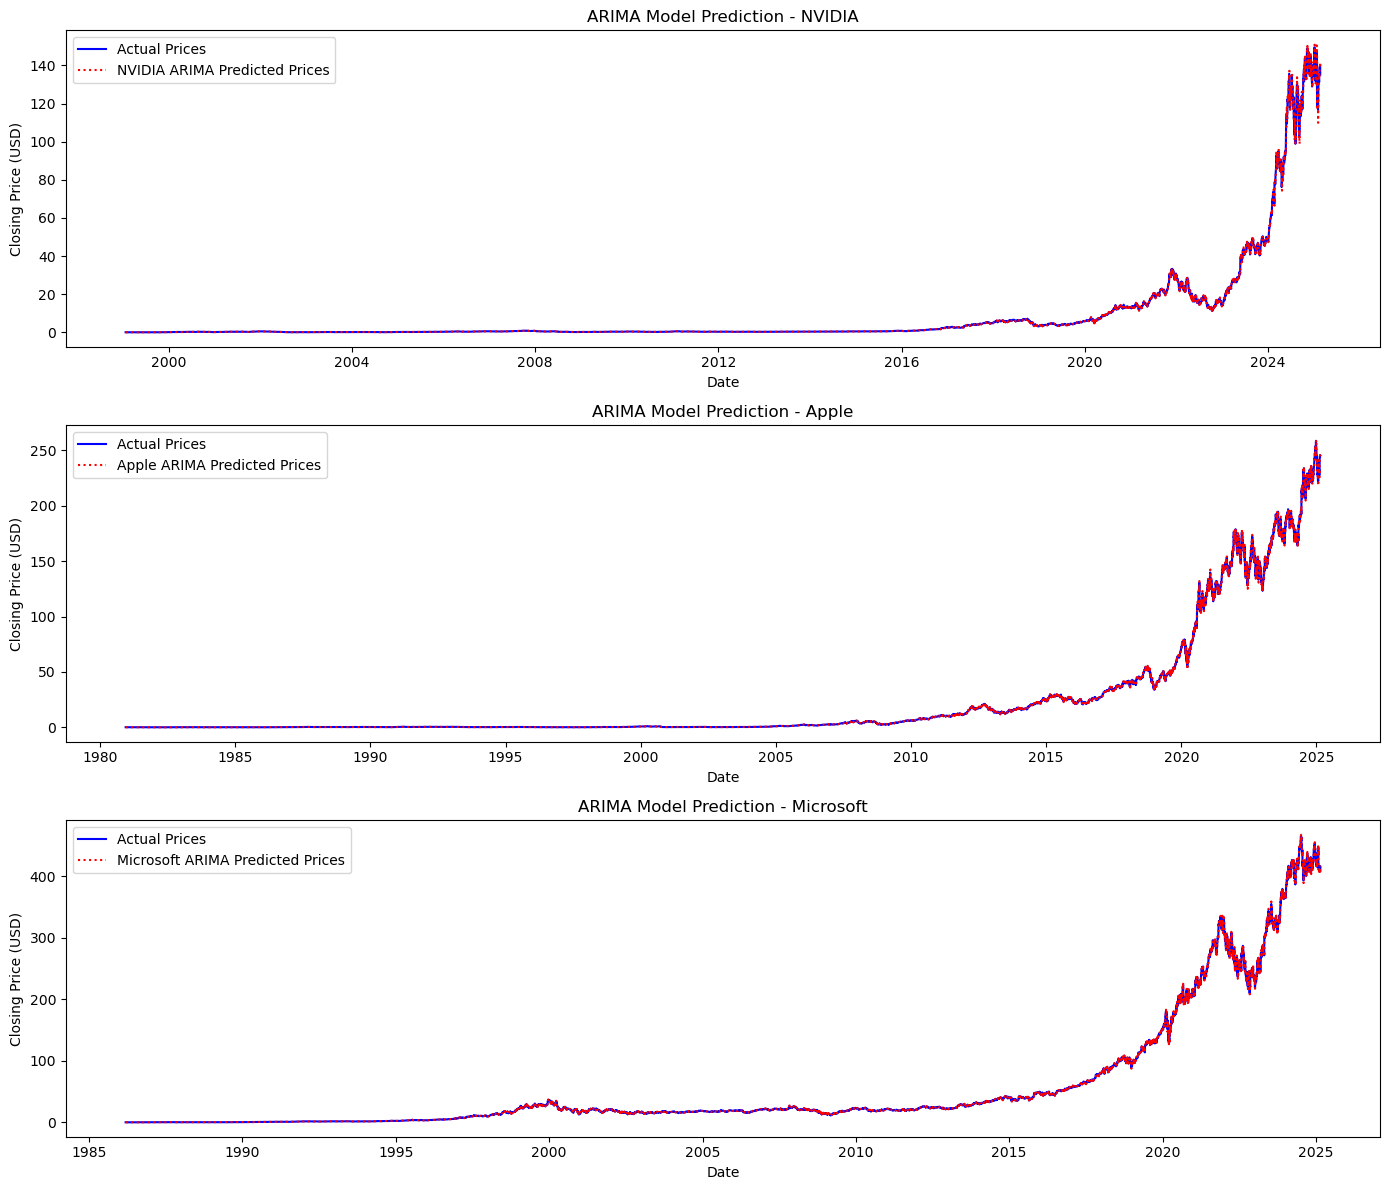

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# NVIDIA
axes[0].plot(nvidia_stock['Close'], label='Actual Prices', color='blue')
axes[0].plot(nvidia_stock['ARIMA_Prediction'], label='NVIDIA ARIMA Predicted Prices', color='red', linestyle='dotted')
axes[0].set_title('ARIMA Model Prediction - NVIDIA')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Closing Price (USD)')
axes[0].legend()

# Apple
axes[1].plot(apple_stock['Close'], label='Actual Prices', color='blue')
axes[1].plot(apple_stock['ARIMA_Prediction'], label='Apple ARIMA Predicted Prices', color='red', linestyle='dotted')
axes[1].set_title('ARIMA Model Prediction - Apple')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Closing Price (USD)')
axes[1].legend()

# Microsoft
axes[2].plot(microsoft_stock['Close'], label='Actual Prices', color='blue')
axes[2].plot(microsoft_stock['ARIMA_Prediction'], label='Microsoft ARIMA Predicted Prices', color='red', linestyle='dotted')
axes[2].set_title('ARIMA Model Prediction - Microsoft')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Closing Price (USD)')
axes[2].legend()

plt.tight_layout()
plt.show()

In [20]:
def evaluate_arima_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (abs((y_true-y_pred)/y_true).mean())*100
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Performance Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R² Score: {r2:.4f}")
    print("-" * 40)


In [21]:
# Evaluate ARIMA for NVIDIA
evaluate_arima_model(nvidia_stock['Close'], nvidia_stock['ARIMA_Prediction'], "NVIDIA ARIMA")

# Evaluate ARIMA for Apple
evaluate_arima_model(apple_stock['Close'], apple_stock['ARIMA_Prediction'], "Apple ARIMA")

# Evaluate ARIMA for Microsoft
evaluate_arima_model(microsoft_stock['Close'], microsoft_stock['ARIMA_Prediction'], "Microsoft ARIMA")

NVIDIA ARIMA Performance Metrics:
RMSE: 0.9218
MAE: 0.2317
MAPE: 2.80%
R² Score: 0.9985
----------------------------------------
Apple ARIMA Performance Metrics:
RMSE: 1.0247
MAE: 0.3356
MAPE: 2.11%
R² Score: 0.9996
----------------------------------------
Microsoft ARIMA Performance Metrics:
RMSE: 1.9984
MAE: 0.7753
MAPE: 1.61%
R² Score: 0.9996
----------------------------------------


We see here our model has excellent performance as displayed by our plots, this is also suspicious the model may be overfitting. Let's implement cross validation to check if our model is able to generalize well.

In [22]:
# Define a function for expanding window cross-validation
def time_series_cross_validation(data, order, n_splits=5):
    """
    Perform expanding window time series cross-validation for ARIMA model.

    Parameters:
    - data: pandas Series of stock closing prices.
    - order: ARIMA order (p, d, q).
    - n_splits: Number of folds for cross-validation.

    Returns:
    - avg_rmse, avg_mae, avg_mape, avg_r2
    """
    rmse_list, mae_list, mape_list, r2_list = [], [], [], []
    
    total_size = len(data)
    test_size = total_size // (n_splits + 1)  # Splitting in n_splits parts

    for i in range(1, n_splits + 1):
        train = data.iloc[: i * test_size]  # Expanding train window
        test = data.iloc[i * test_size : (i + 1) * test_size]  # Fixed test window

        # Fit ARIMA model
        model = ARIMA(train, order=order)
        model_fit = model.fit()

        # Make predictions
        predictions = model_fit.forecast(steps=len(test))

        # Compute evaluation metrics
        rmse = np.sqrt(mean_squared_error(test, predictions))
        mae = mean_absolute_error(test, predictions)
        mape = (np.abs((test - predictions) / test).mean()) * 100
        r2 = r2_score(test, predictions)

        # Store results
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)

    return np.mean(rmse_list), np.mean(mae_list), np.mean(mape_list), np.mean(r2_list)

In [23]:
# Perform cross-validation for NVIDIA, Apple, Microsoft
cv_results_nvidia = time_series_cross_validation(nvidia_stock['Close'], order=(5,2,0))
cv_results_apple = time_series_cross_validation(apple_stock['Close'], order=(5,2,0))
cv_results_microsoft = time_series_cross_validation(microsoft_stock['Close'], order=(5,2,0))
    

In [24]:
# Display results
cv_results = {
    "Stock": ["NVIDIA", "Apple", "Microsoft"],
    "Avg RMSE": [cv_results_nvidia[0], cv_results_apple[0], cv_results_microsoft[0]],
    "Avg MAE": [cv_results_nvidia[1], cv_results_apple[1], cv_results_microsoft[1]],
    "Avg MAPE (%)": [cv_results_nvidia[2], cv_results_apple[2], cv_results_microsoft[2]],
    "Avg R² Score": [cv_results_nvidia[3], cv_results_apple[3], cv_results_microsoft[3]],
}

cv_results_df = pd.DataFrame(cv_results)
cv_results_df

,Stock,Avg RMSE,Avg MAE,Avg MAPE (%),Avg R² Score
0,NVIDIA,8.900227,7.687039,NaN,-668.096605
1,Apple,25.667737,20.960324,NaN,-292.994060
2,Microsoft,213.292345,183.332510,NaN,-2411.707479


**Possible Reasons for Poor Cross-Validation Performance**
1. Non-Stationary Data:
- ARIMA works best with stationary time series. Despite differencing, there is still non-stationarity in the stock prices.

2. Overfitting on Training Data:
- The ARIMA model may be memorizing past data instead of learning patterns that generalize well to new data.

3. Ineffective Hyperparameter Selection:
- The chosen ARIMA (p,d,q) values might not be optimal.
- The model may require fine-tuning or additional feature engineering.

4. Stock Prices are Nonlinear and Highly Volatile:
- Traditional ARIMA struggles with the nonlinearity and sudden shifts in stock prices.